In [3]:
import warnings
import json
import pandas as pd
import torch
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pygments.styles.dracula import background
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

## citation_sentiment_corpus.csv

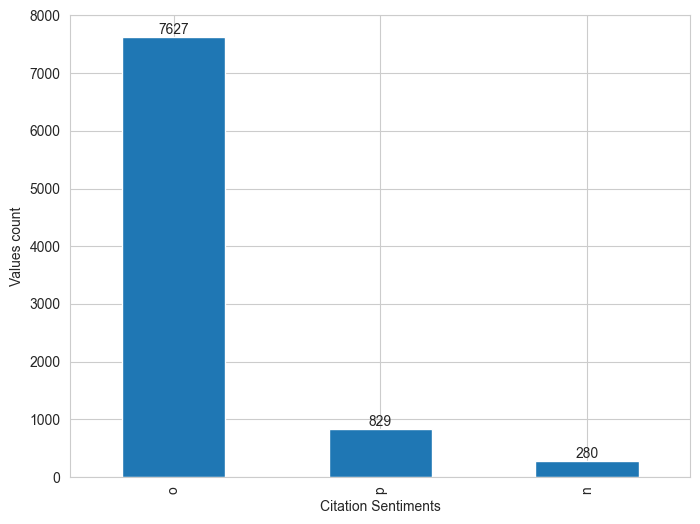

In [4]:
raw_df = pd.read_csv('citation_sentiment_corpus.csv')
fig, ax = plt.subplots(figsize=(8,6))
raw_df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(raw_df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

label2id = {'n': 2, 'p': 1, 'o': 0}
raw_df['Sentiment'] = raw_df['Sentiment'].map(label2id)
# pd.DataFrame({'Sentiment':raw_df['Sentiment'], 'Citation_Text':raw_df['Citation_Text']}).to_csv('raw_corpus.csv', index=False)

## controllable-citation-generation

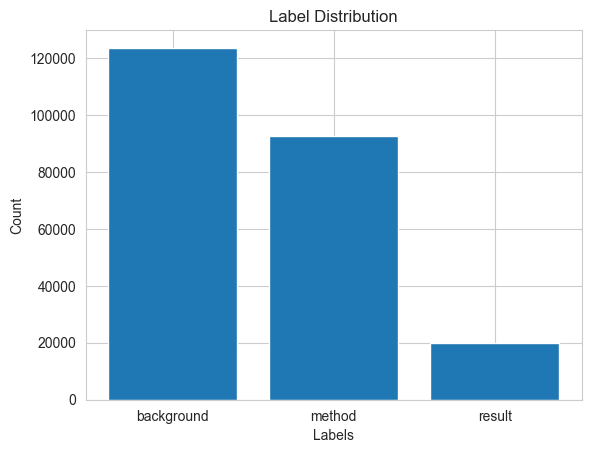

Label counts: {'background': 123605, 'method': 92454, 'result': 19936}


In [5]:
label2id = {"background": 0, "method": 1, "result": 2}
id2label = {v: k for k, v in label2id.items()}

def read_jsonl(file_path):
    citations = []
    intents = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line.strip())
            citation = entry.get('citation')
            citation_intent = entry.get('citation_intent')
            if citation and citation_intent:
                citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                citations.append(citation)
                intents.append(citation_intent_id)
    return citations, intents

train_citations, train_intents = read_jsonl('controllable-citation-generation/train.jsonl')
test_citations, test_intents = read_jsonl('controllable-citation-generation/test.jsonl')
val_citations, val_intents = read_jsonl('controllable-citation-generation/val.jsonl')
data = train_intents + test_intents + val_intents

label_counts = Counter(data)
labels, counts = zip(*label_counts.items())
labels = [id2label[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

print("Label counts:", dict(zip(labels, counts)))

## citation_sentiment_corpus_balanced.csv

In [6]:
DATA_PATH = 'citation_sentiment_corpus_balanced.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(7720, 3)


,Citation_Text,Sentiment,Source
0,…for ovarian and other similar cancer cell lin...,1,original
1,akov and Hearst solved relational similarity...,1,original
2,Steps 3 to 3 can be done efficiently using t...,1,original
3,Our model exploits the same kind of tag-n-gram...,1,original
4,Standard sequence prediction models are highly...,1,original


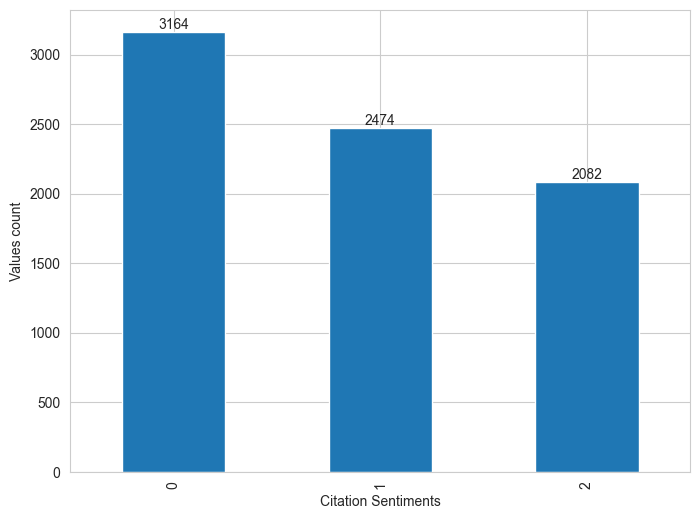

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## corpus.txt

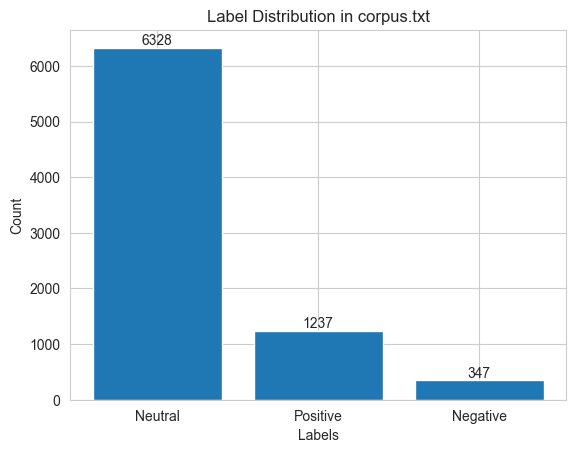

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

def count_labels(filepath):
    label_counter = Counter()
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                label_counter[label] += 1
    return label_counter

# Example usage
filepath = 'corpus.txt'
label_counts = count_labels(filepath)

# Plotting the bar chart
labels, counts = zip(*label_counts.items())
label_names = ['Neutral', 'Positive', 'Negative']
label_names = [label_names[label] for label in labels]

plt.bar(label_names, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in corpus.txt')

# Annotate the counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [9]:
import pandas as pd

def txt_to_csv(filepath, output_csv):
    sentences, labels = [], []
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                sentence = i[1]
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                sentences.append(sentence)
                labels.append(label)
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame({'Sentiment': labels, 'Citation_Text': sentences})
    df.to_csv(output_csv, index=False)

# Example usage
# txt_to_csv('corpus.txt', 'corpus.csv')
# df = pd.read_csv('corpus.csv')
# df.head(20)

## train_data_aug1.csv

In [11]:
# df_aug = pd.read_csv('train_data_aug1.csv')
# df_aug.head(20)

## intent_classification_results.csv

In [42]:
df_intent = pd.read_csv('../output/corpus_with_intent.csv')
df_intent

,text,sentiment,intent,confidence
0,Inter-annotator agreement was determined for s...,0,background,0.95
1,in defined the similarity between two concep...,0,background,0.95
2,", a robust risk minimization classifier, base...",0,method,0.95
3,While work on subjectivity analysis in other l...,0,background,0.95
4,Minor variants support voted perceptron and ...,0,background,0.95
...,...,...,...,...
7907,The second approximation proposed in takes i...,0,background,0.95
7908,Thenthewordalignment is refined by performing ...,0,method,0.95
7909,"For a sequential learning algorithm, we make u...",0,method,0.95
7910,Phrase-based decoding is a dominant formalis...,1,background,0.95


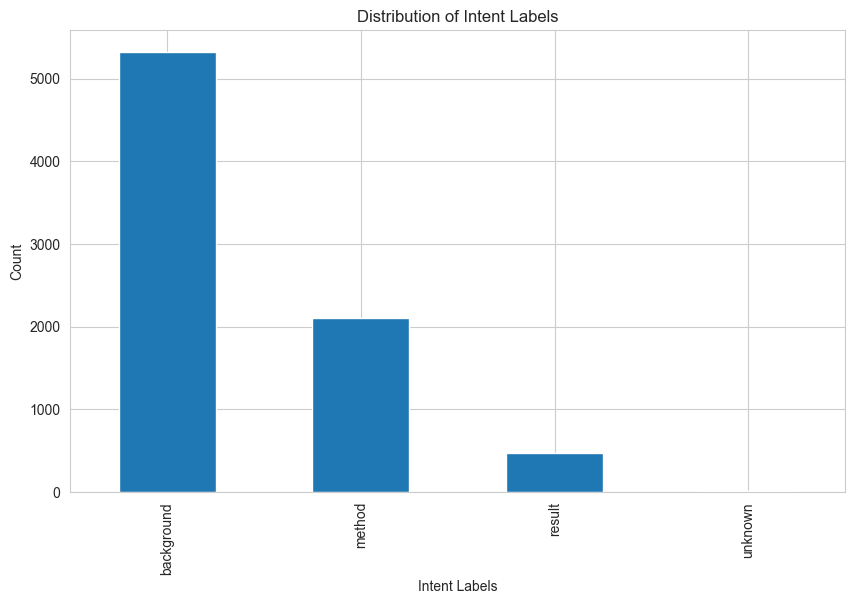

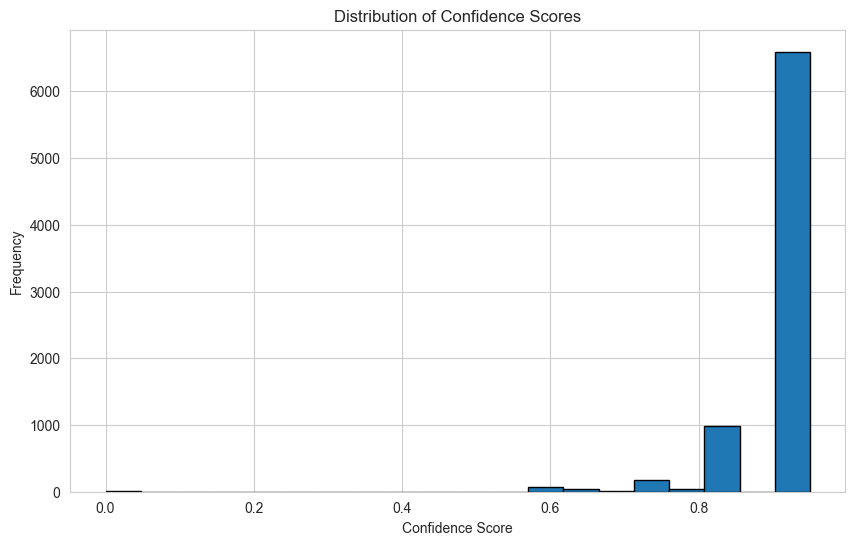

In [43]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each intent label
intent_counts = df_intent['intent'].value_counts()

# Plot the distribution of intent labels
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.xlabel('Intent Labels')
plt.ylabel('Count')
plt.title('Distribution of Intent Labels')
plt.show()

# Plot the distribution of confidence scores
plt.figure(figsize=(10, 6))
df_intent['confidence'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.show()

In [44]:
# Display rows with the label 'unknown'
unknown_samples = df_intent[df_intent['intent'] == 'unknown']
print("Samples with 'unknown' intent:")
unknown_samples

Samples with 'unknown' intent:


,text,sentiment,intent,confidence
252,A large corpus is vahmble as a source of such ...,0,unknown,0.75
521,Due to space we do not describe step 8 in deta...,0,unknown,0.60
540,A similar observation was made in .,0,unknown,0.60
573,6 Concluding remarks Our work presents a set o...,0,unknown,0.00
1088,791 and score the alignment template models ph...,0,unknown,0.65
1132,The other 5 have been suggested for Dutch by .,0,unknown,0.75
1913,Given a manually compiled lexicon containing w...,0,unknown,0.00
3009,of the position infer marion of words at ltlat .,0,unknown,0.95
3629,While these are based on a relatively few numb...,0,unknown,0.00
4179,also worked on one of our data sets.,0,unknown,0.60


In [45]:
# Display rows with confidence score below 0.8
low_confidence_samples = df_intent[df_intent['confidence'] <= 0.6]
print("\nSamples with confidence score below 0.8:")
low_confidence_samples


Samples with confidence score below 0.8:


,text,sentiment,intent,confidence
347,3.2 Results and Discussion The BLEU scores f...,0,background,0.6
387,"), in which translation and language models a...",0,background,0.6
475,In a set of transformational rules is used f...,0,background,0.6
508,Bayesian approaches can also improve performan...,1,background,0.6
521,Due to space we do not describe step 8 in deta...,0,unknown,0.6
...,...,...,...,...
7310,MEDLINE DT JJ VBN NNS IN DT NN NNS VBP The o...,0,unknown,0.0
7655,This shows that hypothesis features are either...,0,unknown,0.0
7746,"This was used, for example, by in informatio...",0,background,0.6
7824,Another way to look the algorithm is from the ...,0,background,0.6


In [46]:
from torch.utils.data import DataLoader
from scipy.stats import chi2_contingency
from typing import Tuple, Dict
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
import seaborn as sns

class LabelCorrelationAnalyzer:
    def __init__(self, sentiment_labels: np.ndarray, intent_labels: np.ndarray, sentiment_labelmap: dict, intent_labelmap: dict):
        """
        Initialize the analyzer

        Args:
            sentiment_labels: Array of sentiment labels
            intent_labels: Array of intent labels
            sentiment_labelmap: Dictionary mapping sentiment labels to categories
            intent_labelmap: Dictionary mapping intent labels to categories
        """
        self.sentiment_labels = sentiment_labels
        self.intent_labels = intent_labels
        self.sentiment_labelmap = sentiment_labelmap
        self.intent_labelmap = intent_labelmap
        self.sentiment_classes = np.unique(sentiment_labels)
        self.intent_classes = np.unique(intent_labels)

    def get_contingency_table(self) -> pd.DataFrame:
        """Compute the contingency table"""
        contingency = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='all'  # Compute joint probability distribution
        )
        return contingency

    def chi_square_test(self) -> Tuple[float, float]:
        """Perform chi-square independence test"""
        contingency = pd.crosstab(self.sentiment_labels, self.intent_labels)
        chi2, p_value = chi2_contingency(contingency)[:2]
        return chi2, p_value

    def mutual_information(self) -> Tuple[float, float]:
        """Compute mutual information and normalized mutual information"""
        mi = mutual_info_score(self.sentiment_labels, self.intent_labels)
        nmi = normalized_mutual_info_score(
            self.sentiment_labels,
            self.intent_labels,
            average_method='arithmetic'
        )
        return mi, nmi

    def conditional_probabilities(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Compute conditional probabilities"""
        # P(intent|sentiment)
        p_intent_given_sentiment = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='index'
        )

        # P(sentiment|intent)
        p_sentiment_given_intent = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='columns'
        )

        return p_intent_given_sentiment, p_sentiment_given_intent

    def plot_heatmap(self, matrix: pd.DataFrame, title: str):
        """Plot heatmap"""
        # Map numerical labels to categories
        matrix.index = [self.sentiment_labelmap[label] for label in matrix.index]
        matrix.columns = [self.intent_labelmap[label] for label in matrix.columns]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            matrix,
            annot=True,
            fmt='.2f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Probability'}
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def analyze_label_correlations(self):
        """Perform full correlation analysis"""
        # 1. Compute and display joint distribution
        joint_dist = self.get_contingency_table()
        print("Joint Distribution:")
        print(joint_dist)
        print("\n")

        # 2. Chi-square test
        chi2, p_value = self.chi_square_test()
        print(f"Chi-square test results:")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")
        print("\n")

        # 3. Mutual information analysis
        mi, nmi = self.mutual_information()
        print(f"Mutual Information Analysis:")
        print(f"Mutual Information: {mi:.4f}")
        print(f"Normalized Mutual Information: {nmi:.4f}")
        print("\n")

        # 4. Conditional probability analysis
        p_intent_given_sentiment, p_sentiment_given_intent = self.conditional_probabilities()

        # 5. Visualization
        self.plot_heatmap(joint_dist, "Joint Distribution of Sentiment and Intent")
        self.plot_heatmap(p_intent_given_sentiment, "P(Intent|Sentiment)")
        self.plot_heatmap(p_sentiment_given_intent, "P(Sentiment|Intent)")

    def get_label_statistics(self) -> Dict:
        """Compute label statistics"""
        stats = {
            'sentiment_distribution': pd.Series(self.sentiment_labels).value_counts().to_dict(),
            'intent_distribution': pd.Series(self.intent_labels).value_counts().to_dict(),
            'total_samples': len(self.sentiment_labels),
            'sentiment_classes': len(self.sentiment_classes),
            'intent_classes': len(self.intent_classes)
        }
        return stats

    @staticmethod
    def from_dataloader(dataloader: DataLoader) -> 'LabelCorrelationAnalyzer':
        """Create analyzer from DataLoader"""
        sentiment_labels = []
        intent_labels = []

        for batch in dataloader:
            sentiment_labels.extend(batch['sentiment_labels'].numpy())
            intent_labels.extend(batch['intent_labels'].numpy())

        return LabelCorrelationAnalyzer(
            np.array(sentiment_labels),
            np.array(intent_labels)
        )


df_intent = df_intent[df_intent['intent'] != 'unknown'] # Remove unknown intent labels
df_intent = df_intent[df_intent['confidence'] > 0.8] # Filter out low confidence scores

sentiment_id2label = {0: 'neutral', 1: 'positive', 2: 'negative'}
intent_id2label = {0: 'background', 1: 'method', 2: 'result'}
intent_label2id = {'background': 0, 'method': 1, 'result': 2}
df_intent['intent'] = df_intent['intent'].map(intent_label2id).astype(int)

sentiment_labels = df_intent['sentiment'].tolist()
intent_labels = df_intent['intent'].tolist()

Joint Distribution:
col_0         0         1         2
row_0                              
0      0.510765  0.254656  0.034077
1      0.124158  0.020473  0.011887
2      0.026549  0.001981  0.015454


Chi-square test results:
Chi-square statistic: 725.84
p-value: 0.0000


Mutual Information Analysis:
Mutual Information: 0.0359
Normalized Mutual Information: 0.0510




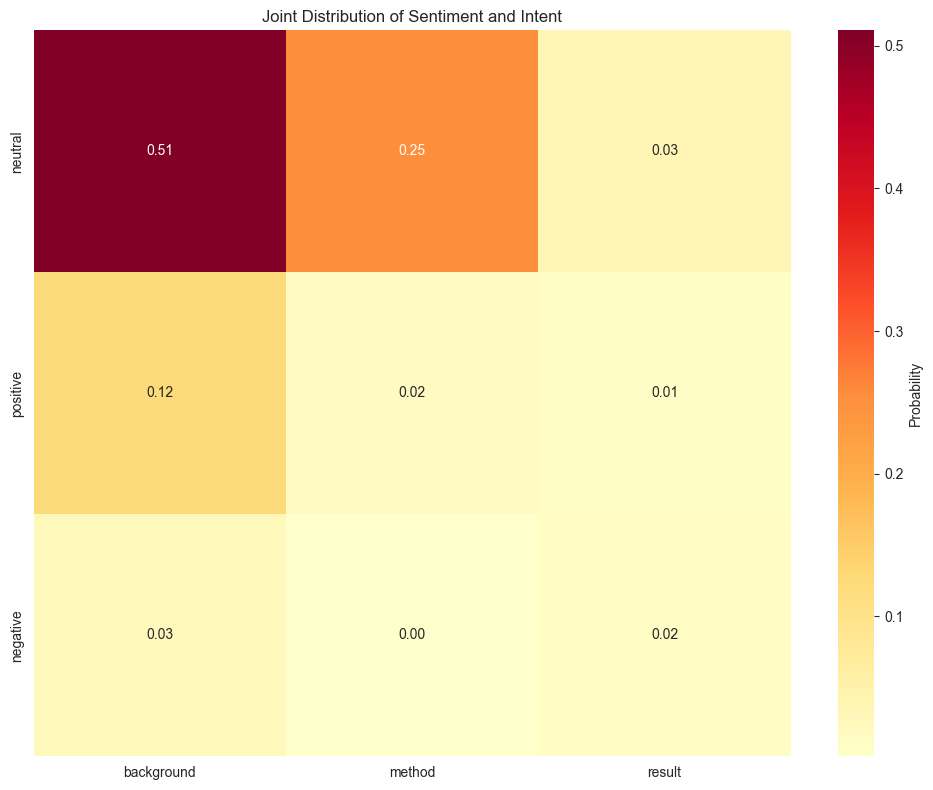

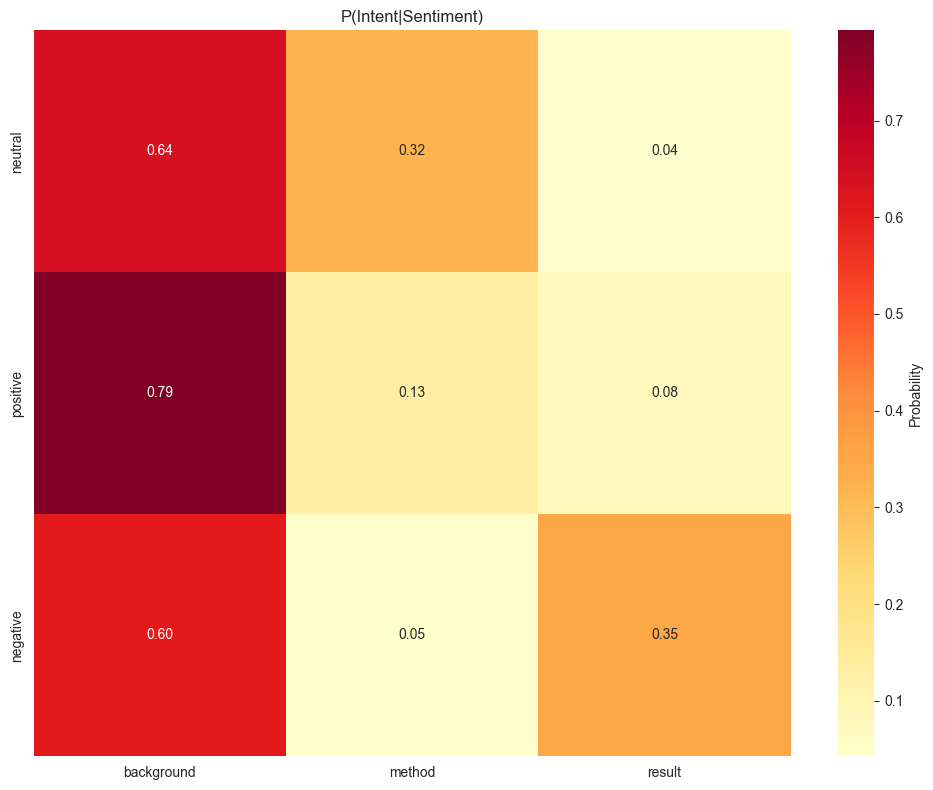

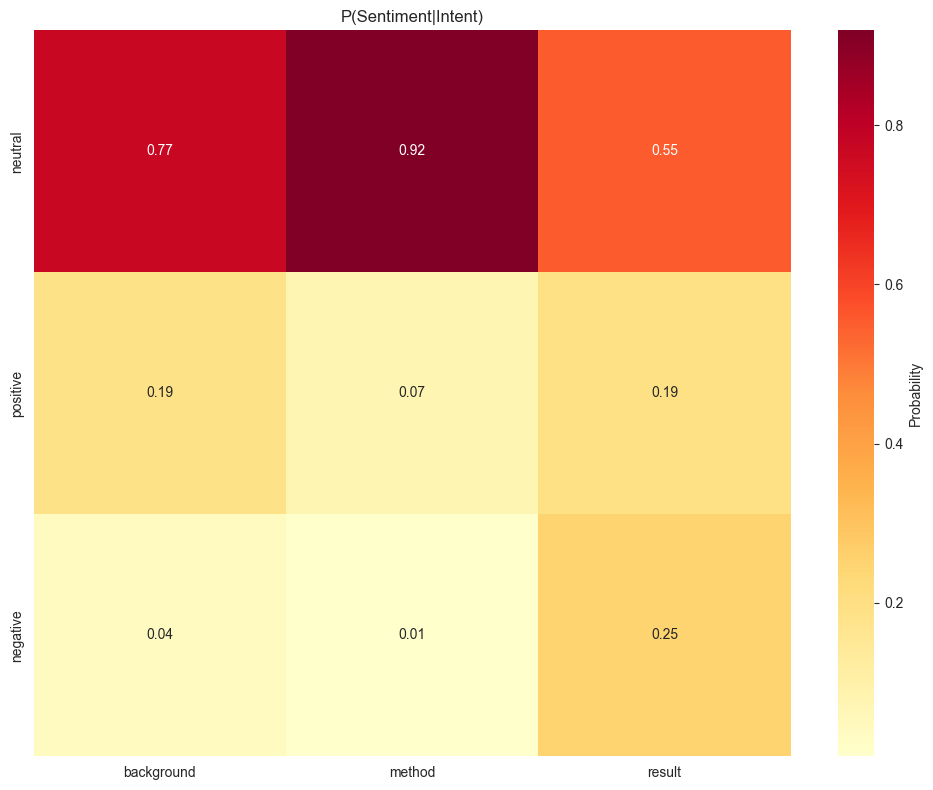

Label Statistics: {'sentiment_distribution': {0: 6053, 1: 1185, 2: 333}, 'intent_distribution': {0: 5008, 1: 2098, 2: 465}, 'total_samples': 7571, 'sentiment_classes': 3, 'intent_classes': 3}


In [48]:
# Convert to numpy arrays
sentiment_labels = np.array(sentiment_labels)# 2: negative, 0: neutral, 1: positive
intent_labels = np.array(intent_labels)# 0: background, 1: method, 2: result

# Assuming sentiment_labels and intent_labels are already defined as numpy arrays
analyzer = LabelCorrelationAnalyzer(sentiment_labels, intent_labels, sentiment_id2label, intent_id2label)

# Run full analysis
analyzer.analyze_label_correlations()

# Get label statistics
stats = analyzer.get_label_statistics()
print("Label Statistics:", stats)

## CSA_raw_dataset

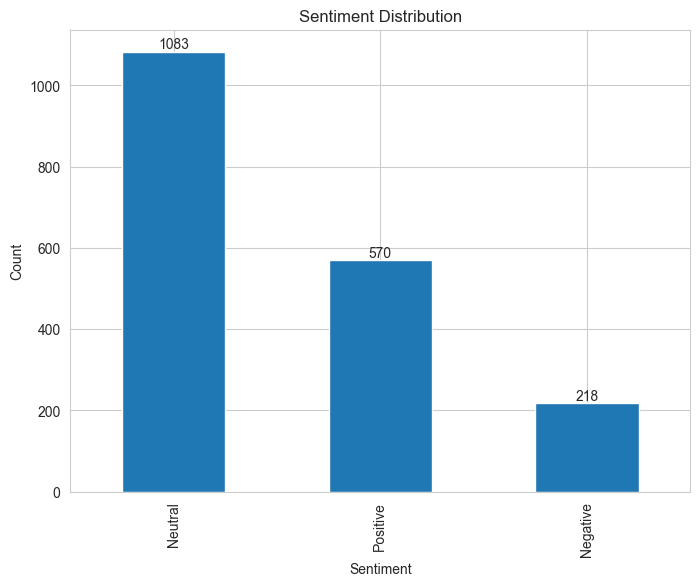

In [35]:
df_neutral = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEUTRAL.csv')
df_negative = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEGATIVE.csv')
df_positive = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/POSITIVE.csv')
df_neutral['Sentiment'] = 'Neutral'
df_negative['Sentiment'] = 'Negative'
df_positive['Sentiment'] = 'Positive'

df_neutral.columns = ['Text'] + list(df_neutral.columns[1:])
df_negative.columns = ['Text'] + list(df_negative.columns[1:])
df_positive.columns = ['Text'] + list(df_positive.columns[1:])

df_combined = pd.concat([df_neutral[['Text', 'Sentiment']], df_negative[['Text', 'Sentiment']], df_positive[['Text', 'Sentiment']]], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True) # Shuffle the rows
df_combined.to_csv('CSA_raw_dataset/athar_context_full_derived/combined.csv', index=False)
sentiment_counts = df_combined['Sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
sentiment_counts.plot(kind='bar', ax=ax)
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [36]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871 entries, 0 to 1870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       1871 non-null   object
 1   Sentiment  1871 non-null   object
dtypes: object(2)
memory usage: 29.4+ KB


In [37]:
df_combined.head()

,Text,Sentiment
0,Our approach is based on the empirical examina...,Neutral
1,We seek to find a partition of the vocabulary ...,Positive
2,Our specific approach is based on contribution...,Neutral
3,Err510,Neutral
4,An alternative approach to semantic role label...,Positive


In [38]:
df_critical = pd.read_csv('20220206_CORPUS_critical_citations_DATA_PAPER.csv')
df_critical

,ID,Source,Source_Paper_ID,Context
0,3,Athar_2011,D08-1067,"For comparison purposes, we revisit a fully ge..."
1,4,Athar_2011,D08-1067,"For comparison purposes, we revisit Haghighi a..."
2,5,Athar_2011,W03-0806,"For example, 10 million words of the American ..."
3,6,Athar_2011,C04-1005,"For example, the statistical word alignment in..."
4,7,Athar_2011,P06-1096,"For example, we would like to know that if a (..."
...,...,...,...,...
500,726,Manually_collected_FB_PG,10.1007/s11192-022-04540-1,"For example, it is not easy for us to replicat..."
501,727,Manually_collected_FB_PG,10.1007/s11192-022-04540-1,"However, for de Gouveia and Inglesi-Lotz (2021..."
502,728,Manually_collected_FB_PG,10.1007/s11192-022-04540-1,Some climate change-related keywords were prov...
503,729,Manually_collected_FB_PG,10.1007/s11192-022-04540-1,"Luckily, from the net increase rate perspectiv..."


In [39]:
def load_negative_text_unrepeated(filepath='../data/20220206_CORPUS_critical_citations_DATA_PAPER.csv'):
    df = pd.read_csv(filepath)
    df = df[df['Source'] != 'Athar_2011']

    return df['Context'].tolist()

negative_texts = load_negative_text_unrepeated()

In [40]:
# raw_df = pd.read_csv('citation_sentiment_corpus.csv')
# negative_citation_texts = raw_df[raw_df['Sentiment'] == 'n']['Citation_Text'].tolist()
# positive_citation_texts = raw_df[raw_df['Sentiment'] == 'p']['Citation_Text'].tolist()
# neutral_citation_texts = raw_df[raw_df['Sentiment'] == 'o']['Citation_Text'].tolist()

raw_df = pd.read_csv('corpus.csv')
negative_citation_texts = raw_df[raw_df['Sentiment'] == 2]['Citation_Text'].tolist()
positive_citation_texts = raw_df[raw_df['Sentiment'] == 1]['Citation_Text'].tolist()
neutral_citation_texts = raw_df[raw_df['Sentiment'] == 0]['Citation_Text'].tolist()

combined_negative_texts = negative_texts + negative_citation_texts

df_negative = pd.DataFrame({'Text': combined_negative_texts, 'Sentiment': 'Negative'})
df_positive = pd.DataFrame({'Text': positive_citation_texts, 'Sentiment': 'Positive'})
df_neutral = pd.DataFrame({'Text': neutral_citation_texts, 'Sentiment': 'Neutral'})
df_combined = pd.concat([df_neutral[['Text', 'Sentiment']], df_positive[['Text', 'Sentiment']], df_negative[['Text', 'Sentiment']]], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
# df_combined.to_csv('citation_sentiment_corpus_expand.csv', index=False)

df_combined.info()

FileNotFoundError: [Errno 2] No such file or directory: 'corpus.csv'

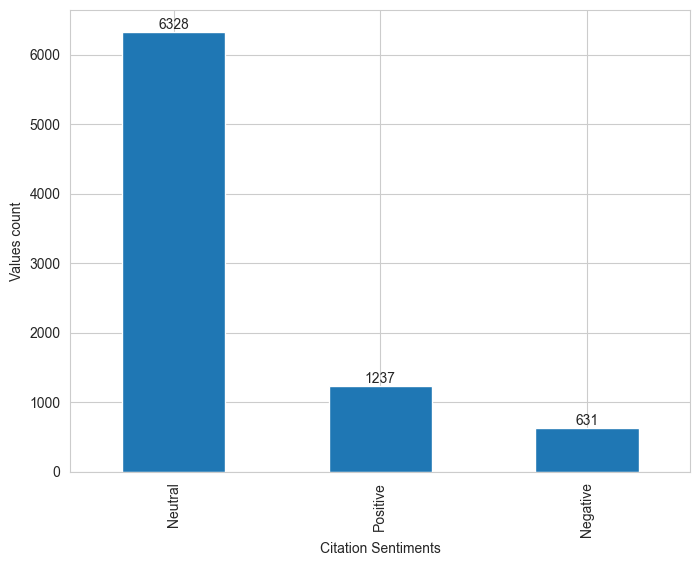

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
df_combined.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df_combined.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## 比较差异 corpus.txt和citation_sentiment_corpus.csv

In [22]:
def compare_csv_files(file1_path, file2_path):
    """
    比较两个CSV文件的差异
    
    Parameters:
    file1_path (str): 第一个CSV文件的路径
    file2_path (str): 第二个CSV文件的路径
    
    Returns:
    tuple: 包含不同分析结果的字典和DataFrame
    """
    # 读取CSV文件
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    # 确保列名一致
    df1.columns = ['Sentiment', 'Citation_Text']
    df2.columns = ['Sentiment', 'Citation_Text']
    
    # 1. 找出相同Citation_Text但Sentiment不同的情况
    # 创建两个DataFrame的合并，基于Citation_Text
    merged_diff = pd.merge(
        df1, 
        df2, 
        on='Citation_Text', 
        suffixes=('_new', '_raw'),
        how='inner'
    )
    
    # 筛选出标签不同的行
    different_labels = merged_diff[
        merged_diff['Sentiment_new'] != merged_diff['Sentiment_raw']
    ]
    
    # 2. 找出文件1独有的文本
    unique_to_file1 = df1[~df1['Citation_Text'].isin(df2['Citation_Text'])]
    
    # 3. 找出文件2独有的文本
    unique_to_file2 = df2[~df2['Citation_Text'].isin(df1['Citation_Text'])]
    
    # 生成统计信息
    stats = {
        'total_rows_file1': len(df1),
        'total_rows_file2': len(df2),
        'different_labels_count': len(different_labels),
        'unique_to_file1_count': len(unique_to_file1),
        'unique_to_file2_count': len(unique_to_file2)
    }
    
    # 保存结果到CSV文件
    different_labels.to_csv('different_labels.csv', index=False)
    unique_to_file1.to_csv('unique_to_file1.csv', index=False)
    unique_to_file2.to_csv('unique_to_file2.csv', index=False)
    
    return stats, different_labels, unique_to_file1, unique_to_file2

stats, diff_labels, unique1, unique2 = compare_csv_files('corpus.csv', 'raw_corpus.csv')
print("\n=== 分析统计 ===")
print(f"文件1总行数: {stats['total_rows_file1']}")
print(f"文件2总行数: {stats['total_rows_file2']}")
print(f"标签不同的文本数量: {stats['different_labels_count']}")
print(f"文件1独有的文本数量: {stats['unique_to_file1_count']}")
print(f"文件2独有的文本数量: {stats['unique_to_file2_count']}")

print("\n结果已保存到以下文件：")
print("- different_labels.csv (标签不同的文本)")
print("- unique_to_file1.csv (文件1独有的文本)")
print("- unique_to_file2.csv (文件2独有的文本)")


=== 分析统计 ===
文件1总行数: 7912
文件2总行数: 8736
标签不同的文本数量: 2
文件1独有的文本数量: 7896
文件2独有的文本数量: 8719

结果已保存到以下文件：
- different_labels.csv (标签不同的文本)
- unique_to_file1.csv (文件1独有的文本)
- unique_to_file2.csv (文件2独有的文本)
